# Bayesian Analysis Using PyMC3

Statistical inference is a process of learning from incomplete or imperfect (error-contaminated) data. Can account for this "imperfection" using either a sampling model or a measurement error model.

### Statistical hypothesis testing

The *de facto* standard for statistical inference is statistical hypothesis testing. The goal of hypothesis testing is to evaluate a **null hypothesis**. There are two possible outcomes:

- reject the null hypothesis
- fail to reject the null hypothesis

Rejection occurs when a chosen test statistic is higher than some pre-specified threshold valuel; non-rejection occurs otherwise.

Notice that neither outcome says anything about the quantity of interest, the **research hypothesis**. 

Setting up a statistical test involves several subjective choices by the user that are rarely justified based on the problem or decision at hand:

- statistical test to use
- null hypothesis to test
- significance level

Choices are often based on arbitrary criteria, including "statistical tradition" (Johnson 1999). The resulting evidence is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

Most importantly to applied users, the results of statistical hypothesis tests are very easy to misinterpret. 

### Estimation 

Instead of testing, a more informative and effective approach for inference is based on **estimation** (be it frequentist or Bayesian). That is, rather than testing whether two groups are different, we instead pursue an estimate of *how different* they are, which is fundamentally more informative. 

Additionally, we include an estimate of **uncertainty** associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (*epistemic uncertainty*) and uncertainty due to the inherent stochasticity of the system (*aleatory uncertainty*).

## One Group

Before we compare two groups using Bayesian analysis, let's start with an even simpler scenario: statistical inference for one group.

For this we will use Gelman et al.'s (2007) radon dataset. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

>  the US EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

![radon](images/radon.jpg)

Let's import the dataset:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

import warnings
warnings.filterwarnings("ignore")

In [2]:
radon = pd.read_csv('../data/radon.csv', index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


Let's focus on the (log) radon levels measured in a single county (Hennepin). 

Suppose we are interested in:

- whether the mean log-radon value is greater than 4 pCi/L in Hennepin county
- the probability that any randomly-chosen household in Hennepin county has a reading of greater than 4

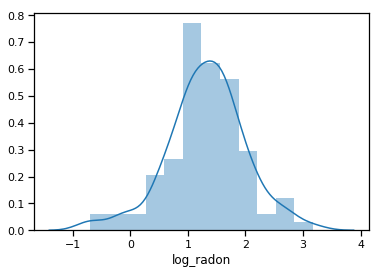

In [3]:
hennepin_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hennepin_radon);

### The model

Recall that the first step in Bayesian inference is specifying a **full probability model** for the problem.

This consists of:

- a likelihood function(s) for the observations
- priors for all unknown quantities

The measurements look approximately normal, so let's start by assuming a normal distribution as the sampling distribution (likelihood) for the data. 

$$y_i \sim N(\mu, \sigma^2)$$

(don't worry, we can evaluate this assumption)

This implies that we have 2 unknowns in the model; the mean and standard deviation of the distribution. 

#### Prior choice

How do we choose distributions to use as priors for these parameters? 

There are several considerations:

- discrete vs continuous values
- the support of the variable
- the available prior information

While there may likely be prior information about the distribution of radon values, we will assume no prior knowledge, and specify a **diffuse** prior for each parameter.

Since the mean can take any real value (since it is on the log scale), we will use another normal distribution here, and specify a large variance to allow the possibility of very large or very small values:

$$\mu \sim N(0, 10^2)$$

For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$

We can encode these in a Python model, using the PyMC3 package, as follows:

In [4]:
from pymc3 import Model, Normal, Uniform

with Model() as radon_model:
    
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)

> ## Software
> Today there is an array of software choices for Bayesians in Python and R, including Stan, PyMC, emcee, TensorFlow Probability. These examples can be replicated in any of these environments.

All that remains is to add the likelihood, which takes $\mu$ and $\sigma$ as parameters, and the log-radon values as the set of observations:

In [5]:
with radon_model:
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hennepin_radon)

Now, we will fit the model using a numerical approach called **Markov chain Monte Carlo (MCMC)**. This will draw samples from the posterior distribution (which cannot be calculated exactly).

In [6]:
from pymc3 import sample

with radon_model:
    
    samples = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1878.11draws/s]


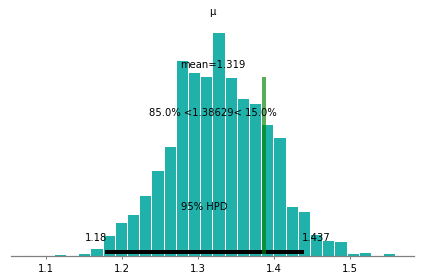

In [7]:
from pymc3 import plot_posterior

plot_posterior(samples, varnames=['μ'], ref_val=np.log(4), color='LightSeaGreen');

The plot shows the posterior distribution of $\mu$, along with an estimate of the 95% posterior **credible interval**. 

The output

    83% < 1.38629 < 17%
    
informs us that the probability of $\mu$ being less than log(4) is 83% and the corresponding probability of being greater than log(4) is 17%.

> The posterior probability that the mean level of household radon in Henneprin County is greater than 4 pCi/L is 0.17.

### Prediction

What is the probability that a given household has a log-radon measurement larger than one? To answer this, we make use of the **posterior predictive distribution**.

$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

where here $z$ is the predicted value and y is the data used to fit the model.

We can estimate this from the posterior samples of the parameters in the model.

In [8]:
mus = samples['μ']
sigmas = samples['σ']

In [9]:
radon_samples = Normal.dist(mus, sigmas).random()

In [10]:
(radon_samples > np.log(4)).mean()

0.4495

> The posterior probability that a randomly-selected household in Henneprin County contains radon levels in excess of 4 pCi/L is ~0.47.

### Model checking

But, ***how do we know this model is any good?***

Its important to check the fit of the model, to see if its assumptions are reasonable. One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

One can choose a particular statistic to compare, such as tail probabilities or quartiles, but here it is useful to compare them graphically.

We already have these simulations from the previous exercise!

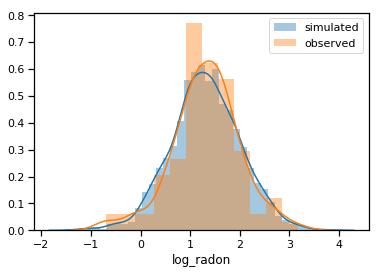

In [11]:
sns.distplot(radon_samples, label='simulated')
sns.distplot(hennepin_radon, label='observed')
plt.legend();

### Prior sensitivity

Its also important to check the sensitivity of your choice of priors to the resulting inference.

Here is the same model, but with drastically different (though still uninformative) priors specified:

In [12]:
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    
    μ = Flat('μ')
    σ = HalfCauchy('σ', 5)
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hennepin_radon)
    
    sensitivity_samples = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2716.97draws/s]


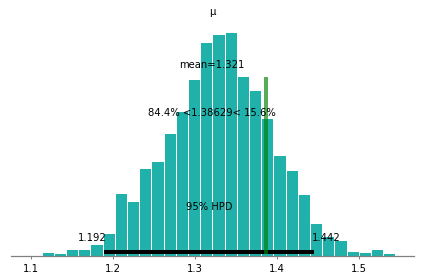

In [13]:
plot_posterior(sensitivity_samples, varnames=['μ'], ref_val=np.log(4), color='LightSeaGreen');

Here is the original model for comparison:

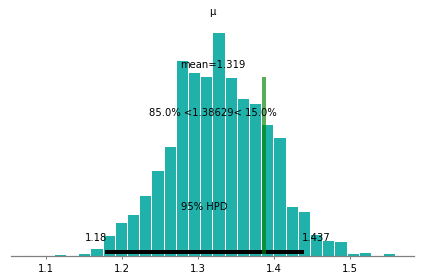

In [14]:
plot_posterior(samples, varnames=['μ'], ref_val=np.log(4), color='LightSeaGreen');

## Two Groups with Continiuous Outcome

To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

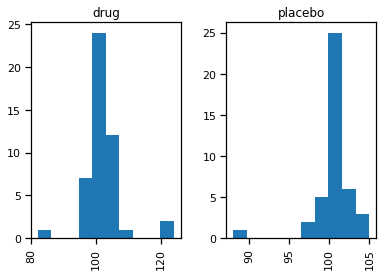

In [15]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group. This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

As a simplifying assumption, we will assume that the degree of normality $\nu$ is the same for both groups. 

### Prior choice

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:

$$\mu_k \sim N(100, 10^2)$$

In [16]:
with Model() as drug_model:
    
    μ_0 = Normal('μ_0', 100, sd=10)
    μ_1 = Normal('μ_1', 100, sd=10)

Similarly, we will use a uniform prior for the standard deviations, with an upper bound of 20.

In [17]:
with drug_model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)

For the degrees-of-freedom parameter $\nu$, we will use an **exponential** distribution with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

In [18]:
from pymc3 import Exponential

with drug_model:
    ν = Exponential('ν_minus_one', 1/29.) + 1


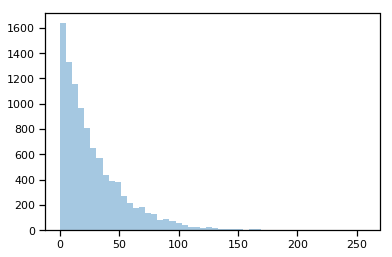

In [19]:
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);

In [20]:
from pymc3 import StudentT

with drug_model:

    drug_like = StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**-2, observed=drug.iq)
    placebo_like = StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**-2, observed=placebo.iq)

Now that the model is fully specified, we can turn our attention to tracking the posterior quantities of interest. Namely, we can calculate the difference in means between the drug and placebo groups.

As a joint measure of the groups, we will also estimate the "effect size", which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but it is a function of all four estimated parameters.

In [21]:
from pymc3 import Deterministic

with drug_model:
    
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    
    effect_size = Deterministic('effect size', 
                        diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))



In [22]:
with drug_model:
    
    drug_trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, σ_1, σ_0, μ_1, μ_0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1045.66draws/s]


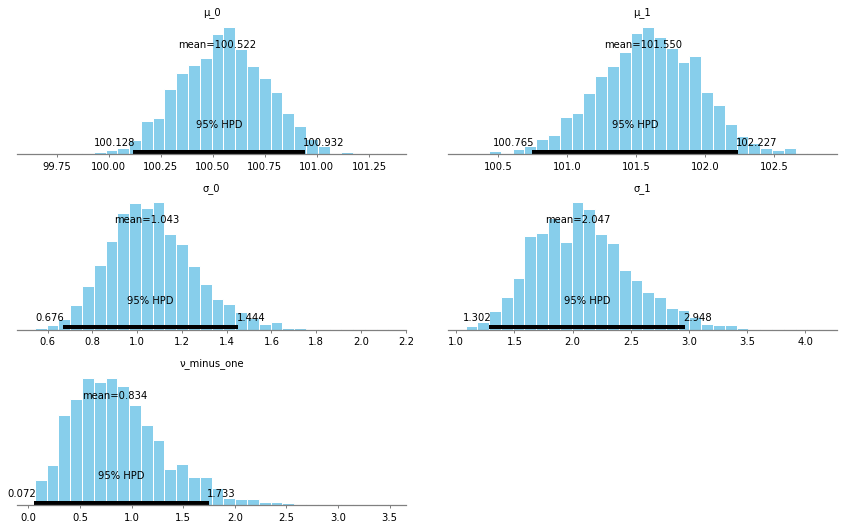

In [25]:
plot_posterior(drug_trace, 
                varnames=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'],
                color='#87ceeb');

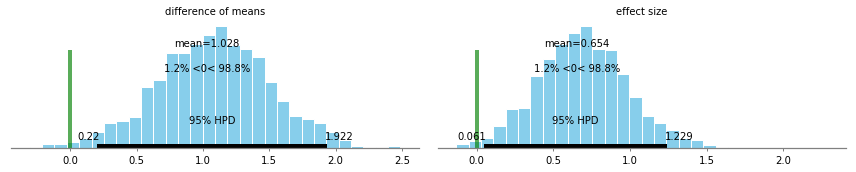

In [26]:
plot_posterior(drug_trace, 
          varnames=['difference of means', 'effect size'],
          ref_val=0,
          color='#87ceeb');

> The posterior probability that the mean IQ of subjects in the treatment group is greater than that of the control group is 0.99.

## Two Groups with Binary Outcome

Now that we have seen how to generalize normally-distributed data to another distribution, we are equipped to analyze other data types. Binary outcomes are common in clinical research: 

- survival/death
- true/false
- presence/absence
- positive/negative

In practice, binary outcomes are encoded as ones (for event occurrences) and zeros (for non-occurrence). A single binary variable is distributed as a **Bernoulli** random variable:

$$f(x \mid p) = p^{x} (1-p)^{1-x}$$

Such events are sometimes reported as sums of individual events, such as the number of individuals in a group who test positive for a condition of interest. Sums of Bernoulli events are distributed as **binomial** random variables.

$$f(x \mid n, p) = \binom{n}{x} p^x (1-p)^{n-x}$$

The parameter in both models is $p$, the probability of the occurrence of an event. In terms of inference, we are typically interested in whether $p$ is larger or smaller in one group relative to another.

To demonstrate the comparison of two groups with binary outcomes using Bayesian inference, we will use a sample pediatric dataset. Data on 671 infants with very low (<1600 grams) birth weight from 1981-87 were collected at Duke University Medical Center. Of interest is the relationship between the outcome intra-ventricular hemorrhage (IVH) and predictor such as birth weight, gestational age, presence of pneumothorax and mode of delivery.

In [27]:
vlbw = pd.read_csv('../data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


To demonstrate binary data analysis, we will try to estimate the difference between the probability of an intra-ventricular hemorrhage for infants with a pneumothorax. 

In [28]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


We will create a binary outcome by combining `definite` and `possible` into a single outcome.

In [29]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

### Prior choice

What should we choose as a prior distribution for $p$?

We could stick with a normal distribution, but note that the value of $p$ is **constrained** by the laws of probability. Namely, we cannot have values smaller than zero nor larger than one. So, choosing a normal distribution will result in ascribing positive probability to unsupported values of the parameter. In many cases, this will still work in practice, but will be inefficient for calculating the posterior and will not accurately represent the prior information about the parameter.

A common choice in this context is the **beta distribution**, a continuous distribution with 2 parameters and whose support is on the unit interval:

$$ f(x \mid \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}$$

- Support: $x \in (0, 1)$
- Mean: $\dfrac{\alpha}{\alpha + \beta}$
- Variance: $\dfrac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$

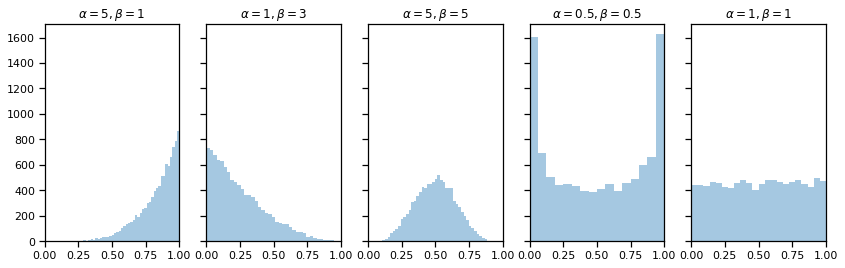

In [30]:
from pymc3 import Beta

params = (5, 1), (1, 3), (5, 5), (0.5, 0.5), (1, 1)

fig, axes = plt.subplots(1, len(params), figsize=(14, 4), sharey=True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Beta.dist(alpha, beta).random(size=10000), ax=ax, kde=False)
    ax.set_xlim(0, 1)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha, beta));

So let's use a beta distribution to model our prior knowledge of the probabilities for both groups. Setting $\alpha = \beta = 1$ will result in a uniform distribution of prior mass:

In [31]:
with Model() as ivh_model:
    
    p = Beta('p', 1, 1, shape=2)

We can now use `p` as the parameter of our Bernoulli likelihood. Here, `x` is a vector of zeros an ones, which will extract the approproate group probability for each subject:

In [32]:
from pymc3 import Bernoulli

with ivh_model:
    
    bb_like = Bernoulli('bb_like', p=p[x], observed=ivh)

Finally, since we are interested in the difference between the probabilities, we will keep track of this difference:

In [33]:
with ivh_model:
    
    p_diff = Deterministic('p_diff', p[1] - p[0])

In [34]:
with ivh_model:
    ivh_trace = sample(1000, init=None)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1636.77draws/s]


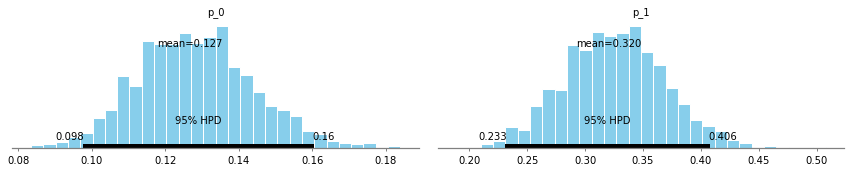

In [35]:
plot_posterior(ivh_trace[100:], varnames=['p'], color='#87ceeb');

We can see that the probability that `p` is larger for the pneumothorax with probability one.

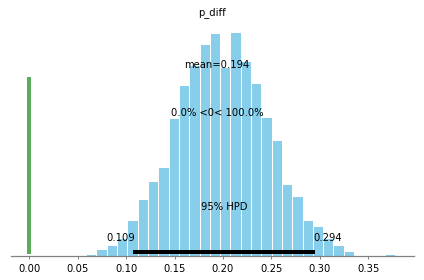

In [36]:
plot_posterior(ivh_trace[100:], varnames=['p_diff'], ref_val=0, color='#87ceeb');

As a final demonstration, let's make this analysis slightly more realistic. Since these are observational data, its probably a bad idea to compare group probabilities without correcting them for **confounding variables**. Individuals may have systematic differences between groups that may explain the difference in observed outcomes that have nothing to do with group membership itself. 

For example, perhaps lower birthweight accounts for the difference, since birthweight is nominally lower in the pneumothorax group:

In [37]:
vlbw.groupby('pneumo').bwt.mean()

pneumo
0.0    1089.395122
1.0    1035.355140
Name: bwt, dtype: float64

Let's add birth weight as a predictor to our model (but first we will center it to aid interpretation):

In [38]:
bwt_centered = (vlbw.bwt - vlbw.bwt.mean()) / vlbw.bwt.std()

How do we add a continuous covariate to this model?

The easiest way to do so is to change the formulation of the model to that of a **generalized linear model (GLM)**. What this does is create a regression model to predict the latent probability of IVH for each individual. 

$$p_i = \mu + \alpha * \text{bwt}_i + \beta * \text{pneumo}_i$$

here, $\mu$ is a baseline probability, $\alpha$ is a coefficient for centered birthweight, and $\beta$ is a coefficient for pneumothorax.

However, this presents a problem as formulated: its very easy to generate combinations of $\mu$, $\alpha$, and $\beta$ that generate values outside the $(0,1)$ interval. To avoid this, we must **transform** this sum in such a way that the unit interval constraint is guaranteed.

One such transformation is the **logit**:

$$x = \text{logit}(p) = \log\left[\frac{p}{1-p}\right]$$

the inverse of this function maps real values of $x$ to values of $p$ on the unit interval:

$$p = \text{invlogit}(x) = \frac{1}{1 + \exp(-x)}$$

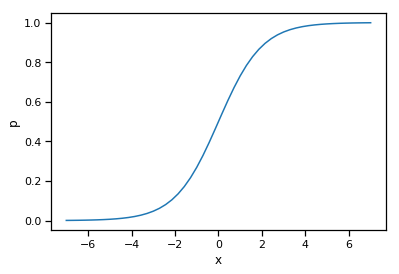

In [39]:
x_range = np.linspace(-7,7)
plt.plot(x_range, 1/(1+np.exp(-x_range)))
plt.xlabel('x')
plt.ylabel('p');

To convert our original model to a GLM, we need to specify priors for the linear model coefficients:

In [40]:
with Model() as ivh_glm:
    
    μ = Normal('μ', 0, sd=10)
    α = Normal('α', 0, sd=10)
    β = Normal('β', 0, sd=10)

Then, apply the `invlogit` transformation to the linear combination of predictors.

The likelihood stays the same.

In [41]:
from pymc3.math import invlogit

with ivh_glm:
        
    p = invlogit(μ + α*bwt_centered + β*x)
    
    bb_like = Bernoulli('bb_like', p=p, observed=ivh)

In [42]:
with ivh_glm:
    trace_glm = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 983.48draws/s]


We can see that the estimate for $\alpha$ is negative, indicating that higher birth weight reduces the baseline probability of IVH. 

The coefficient for $\beta$ is strongly positive.

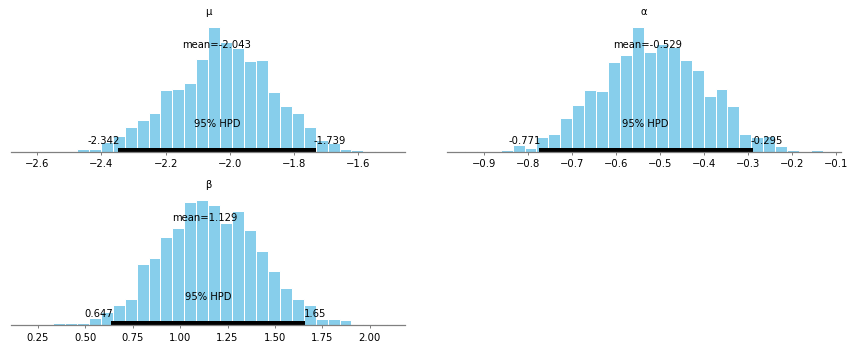

In [43]:
plot_posterior(trace_glm, varnames=['μ', 'α', 'β'], 
               color='#87ceeb');

---
## To Learn More

- Kruschke, J.K. [Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884). 2015. Academic Press / Elsevier. 
- [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) by Cam Davidson Pilon
- [PyMC3 Tutorial Notebooks](https://docs.pymc.io/nb_tutorials/index.html)